In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "ARF"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn017391,MAASEVSYRGNARGESFSSDYCDPNDGGAGEGNSGGFAHFSGEIPA...,801,1
1,Achn023421,MQFFFFLSLLTIRKKKFNGGGGEKKNINAELWQACAGPLVNLPAAG...,882,1
2,Achn024331,MASRNDVQVQKVETINDVSRCNNQGEKDDLYTQLWHACAGPLVHVP...,1801,1
3,Achn034241,MHTGQPKRHLLTTGWSVFVSAKRLVAGDSVLFIWNEKNQLLLGIRR...,662,1
4,Achn043361,MCGLIDLNTVLDGDETTAASFDSPTPSPPPSTSSGALALGSSSSSS...,753,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
975,0.005747,0.001437,0.001437,0.004310,0.001437,0.005747,0.001437,0.002874,0.002874,0.001437,...,0.000000,0.000000,0.0,0.000000,0.002874,0.002874,0.000000,0.0,0.0,0.001437
4469,0.010753,0.002688,0.008065,0.005376,0.008065,0.013441,0.002688,0.000000,0.010753,0.002688,...,0.000000,0.002688,0.0,0.002688,0.000000,0.000000,0.000000,0.0,0.0,0.005376
5941,0.000000,0.000000,0.000000,0.003175,0.000000,0.003175,0.000000,0.000000,0.006349,0.003175,...,0.003175,0.000000,0.0,0.003175,0.000000,0.000000,0.000000,0.0,0.0,0.000000
1354,0.006422,0.000917,0.002752,0.002752,0.000000,0.003670,0.000917,0.000000,0.000917,0.007339,...,0.001835,0.000917,0.0,0.000917,0.004587,0.000917,0.000917,0.0,0.0,0.000000
5644,0.032258,0.004032,0.012097,0.016129,0.000000,0.004032,0.000000,0.000000,0.000000,0.012097,...,0.000000,0.000000,0.0,0.000000,0.000000,0.004032,0.000000,0.0,0.0,0.000000


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (7301, 441)
X_test: (1826, 441)
y_train: (7301,)
y_test: (1826,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 54s 598ms/step - accuracy: 0.5312 - loss: 0.6929

33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5737 - loss: 0.6800   

67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6662 - loss: 0.6190

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7159 - loss: 0.5566 - val_accuracy: 0.9925 - val_loss: 0.0230


Epoch 2/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0269

29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9934 - loss: 0.0252

58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9933 - loss: 0.0254

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9931 - loss: 0.0254

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9930 - loss: 0.0256 - val_accuracy: 0.9870 - val_loss: 0.0393


Epoch 3/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0152

29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9876 - loss: 0.0381

57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9908 - loss: 0.0299

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9922 - loss: 0.0263

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9924 - loss: 0.0256 - val_accuracy: 0.9938 - val_loss: 0.0265


Epoch 4/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0074

30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0130

58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0124

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0117

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0116 - val_accuracy: 0.9938 - val_loss: 0.0184


Epoch 5/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0325

28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0067

56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0054

84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0057

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0058 - val_accuracy: 0.9959 - val_loss: 0.0104


Epoch 6/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.8026e-04

30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0046    

59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0058

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0056

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0055 - val_accuracy: 0.9959 - val_loss: 0.0086


Epoch 7/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.2429e-04

30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 6.1603e-04

59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0015    

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0021

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0022 - val_accuracy: 0.9966 - val_loss: 0.0123


Epoch 8/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0043

31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 0.0018

60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0021

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0038

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0042 - val_accuracy: 0.9973 - val_loss: 0.0119


Epoch 9/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.9074e-04

29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0087    

57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0074

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0068

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0067 - val_accuracy: 0.9918 - val_loss: 0.0302


Epoch 10/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0024

29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0020

58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0024

73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0026

83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0027

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0028 - val_accuracy: 0.9822 - val_loss: 0.0744


Epoch 11/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0274

27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9939 - loss: 0.0143

35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9946 - loss: 0.0127

61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9959 - loss: 0.0095

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0077

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9967 - loss: 0.0076 - val_accuracy: 0.9973 - val_loss: 0.0111


Epoch 12/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 1.1071e-04

28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 4.1358e-04

56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0027    

84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0055

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0059 - val_accuracy: 0.9932 - val_loss: 0.0215


Epoch 13/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 7.5015e-04

31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0020    

61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0019

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0018

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0018 - val_accuracy: 0.9966 - val_loss: 0.0116


Epoch 14/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.1762e-04

30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.1335e-04

59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.1384e-04

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.9234e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.8975e-04 - val_accuracy: 0.9966 - val_loss: 0.0115


Epoch 15/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 1.1976e-04

29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.4987e-04

57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.6877e-04

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.6862e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.6775e-04 - val_accuracy: 0.9966 - val_loss: 0.0125


Epoch 16/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 6.8831e-05

29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.5096e-04

58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.9826e-04

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.2464e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.2698e-04 - val_accuracy: 0.9966 - val_loss: 0.0131


Epoch 17/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 6.6399e-05

27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.4227e-04

54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.5379e-04

83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.5944e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.5898e-04 - val_accuracy: 0.9966 - val_loss: 0.0134


Epoch 18/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 1.0000 - loss: 9.8833e-05

 7/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 5.9579e-05 

21/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.8713e-05

42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.7811e-05

71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.9150e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.9425e-05 - val_accuracy: 0.9966 - val_loss: 0.0155



[Train Accuracy: 100.00% - Test Accuracy: 99.51%]

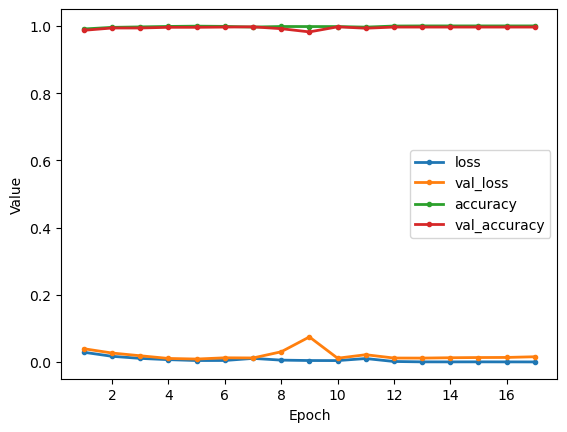

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

31/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 1/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
975,0.001439,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4469,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.002695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5941,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1354,0.002755,0.0,0.0,0.000918,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5644,0.000000,0.0,0.0,0.004049,0.0,0.004049,0.0,0.0,0.0,0.012146,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (7301, 8864)
X_test: (1826, 8864)
y_train: (7301,)
y_test: (1826,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,269,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,312,705 (8.82 MB)

 Trainable params: 2,312,705 (8.82 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 48s 538ms/step - accuracy: 0.5312 - loss: 0.6932

 8/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5255 - loss: 0.6928   

13/92 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5288 - loss: 0.6922

15/92 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5364 - loss: 0.6918

21/92 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5546 - loss: 0.6901

26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5721 - loss: 0.6878

30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5889 - loss: 0.6851

36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6143 - loss: 0.6791

43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6416 - loss: 0.6683

51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6690 - loss: 0.6506

59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6925 - loss: 0.6291

67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7127 - loss: 0.6060

75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7301 - loss: 0.5828

83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7454 - loss: 0.5605

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7588 - loss: 0.5393 

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7619 - loss: 0.5343 - val_accuracy: 0.9986 - val_loss: 0.0059


Epoch 2/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 0.0062

 9/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0050 

17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9997 - loss: 0.0048

25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9996 - loss: 0.0047

32/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9995 - loss: 0.0045

35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9995 - loss: 0.0044

39/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9995 - loss: 0.0043

44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9995 - loss: 0.0041

48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9995 - loss: 0.0041

53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9994 - loss: 0.0040

60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9994 - loss: 0.0039 

67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9994 - loss: 0.0038

75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9994 - loss: 0.0037

83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9994 - loss: 0.0036

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9994 - loss: 0.0036

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9994 - loss: 0.0036 - val_accuracy: 0.9993 - val_loss: 0.0021


Epoch 3/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 5.5154e-04

 9/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.0762e-04 

17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.2470e-04

25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.6649e-04

33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.7116e-04

41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.6515e-04

48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.5877e-04

54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.6884e-04

60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.7628e-04

65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.8188e-04

71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.8762e-04

77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.9132e-04

83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.9700e-04

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.2193e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 7.3801e-04 - val_accuracy: 0.9979 - val_loss: 0.0044


Epoch 4/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 3.7671e-04

 9/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.4042e-04 

17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.0343e-04

25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.1155e-04

33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.5526e-04

41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.0706e-04

49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.6908e-04

57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.3800e-04

65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.1283e-04

72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9546e-04

78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8260e-04

82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.7466e-04

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.6534e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 4.5563e-04 - val_accuracy: 0.9986 - val_loss: 0.0014


Epoch 5/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 9.7572e-05

10/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.7584e-05 

18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.5874e-05

26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.6380e-05

35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.7317e-05

44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.7853e-05

52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.9085e-05

60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0044e-04

68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0188e-04

76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0312e-04

84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0406e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0465e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.0472e-04 - val_accuracy: 0.9986 - val_loss: 0.0015


Epoch 6/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 6.9584e-04

 9/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5027e-04 

18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1922e-04

26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1460e-04

35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0354e-04

42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.9468e-04

49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8640e-04

57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7817e-04

65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7144e-04

73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6518e-04

81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6033e-04

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5578e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.5357e-04 - val_accuracy: 0.9986 - val_loss: 0.0039


Epoch 7/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 1.8106e-04

10/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.5359e-05 

19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.2443e-05

27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.5606e-05

35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0983e-04

43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1787e-04

51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2139e-04

59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2220e-04

68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2158e-04

76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2010e-04

84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1867e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.1696e-04 - val_accuracy: 0.9986 - val_loss: 0.0017


Epoch 8/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 7.8983e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.3723e-05 

17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.5365e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.6686e-05

33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.0675e-05

41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.7387e-05

49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.6028e-05

57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.4821e-05

66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.3634e-05

74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.2467e-05

82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.1426e-05

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.0399e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 5.0230e-05 - val_accuracy: 0.9986 - val_loss: 0.0013


Epoch 9/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 1.9404e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5315e-05 

17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3488e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6500e-05

33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8791e-05

41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0309e-05

49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1026e-05

57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1292e-05

65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1376e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1324e-05

82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1224e-05

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1436e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.1597e-05 - val_accuracy: 1.0000 - val_loss: 8.9551e-04


Epoch 10/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 1.1563e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2366e-05 

17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3035e-05

26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3246e-05

35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5236e-05

43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7211e-05

51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8521e-05

60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9436e-05

68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0025e-05

76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0386e-05

84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0563e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.0659e-05 - val_accuracy: 0.9986 - val_loss: 0.0020


Epoch 11/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 1.6004e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1952e-05 

18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2450e-05

26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3200e-05

34/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3472e-05

43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4537e-05

51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5349e-05

59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5675e-05

67/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5790e-05

75/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5852e-05

83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6449e-05

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7191e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.7352e-05 - val_accuracy: 0.9986 - val_loss: 0.0030


Epoch 12/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 1.9603e-06

 9/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.3501e-06 

17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.1218e-06

25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0187e-05

34/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1724e-05

42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2133e-05

51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2167e-05

60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2097e-05

68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2059e-05

77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1989e-05

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1895e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.1827e-05 - val_accuracy: 0.9986 - val_loss: 0.0017


Epoch 13/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 3.7470e-06

 9/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.6950e-06 

17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.4897e-06

25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.1473e-06

33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.3968e-06

41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.5505e-06

49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.9272e-06

57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.1928e-06

65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.3478e-06

74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.4225e-06

83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.4355e-06

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.4336e-06

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 7.4438e-06 - val_accuracy: 0.9986 - val_loss: 0.0030


Epoch 14/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 8.6822e-07

10/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0247e-05 

19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.9766e-06

28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.9737e-06

37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.4161e-06

46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.9662e-06

55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.3551e-06

63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.9234e-06

72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.3702e-06

81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.6788e-06

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.8978e-06

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 7.9840e-06 - val_accuracy: 0.9993 - val_loss: 0.0011


Epoch 15/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 1.8599e-06

 9/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.3127e-06 

18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.8446e-06

27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.7685e-06

35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.8756e-06

43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.9072e-06

52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.9476e-06

60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.0236e-06

68/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.0458e-06

76/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.0715e-06

84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.1085e-06

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 4.1387e-06 - val_accuracy: 0.9986 - val_loss: 0.0020


Epoch 16/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 1.3361e-06

 9/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7821e-06 

17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.0006e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.5365e-05

33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7438e-05

41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7807e-05

49/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7805e-05

57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7384e-05

65/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.6449e-05

74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.5082e-05

82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.3863e-05

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.2643e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 4.2193e-05 - val_accuracy: 0.9986 - val_loss: 0.0040


Epoch 17/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 3.8705e-07

 9/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1691e-05 

18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0438e-05

26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.1751e-06

34/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.2392e-06

42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.5185e-06

50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.9823e-06

58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.5473e-06

66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.1814e-06

74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.8760e-06

83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.5830e-06

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.3761e-06

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 5.3302e-06 - val_accuracy: 0.9986 - val_loss: 0.0026


Epoch 18/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 1.2933e-06

 9/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.8695e-06 

17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0108e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0160e-05

34/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.5806e-06

42/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.0159e-06

48/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.6368e-06

52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.3940e-06

57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.1326e-06

63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.8472e-06

70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.5383e-06

78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.2383e-06

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.9698e-06

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 6.7509e-06 - val_accuracy: 0.9986 - val_loss: 0.0030


Epoch 19/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 2.5567e-07

 9/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6917e-06 

17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.3366e-06

25/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.1578e-06

33/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.1782e-06

41/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.1918e-06

50/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.1122e-06

58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.0238e-06

66/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9347e-06

74/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.8815e-06

80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.0157e-06

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.1688e-06

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 4.3553e-06 - val_accuracy: 1.0000 - val_loss: 5.8818e-04



[Train Accuracy: 100.00% - Test Accuracy: 99.95%]


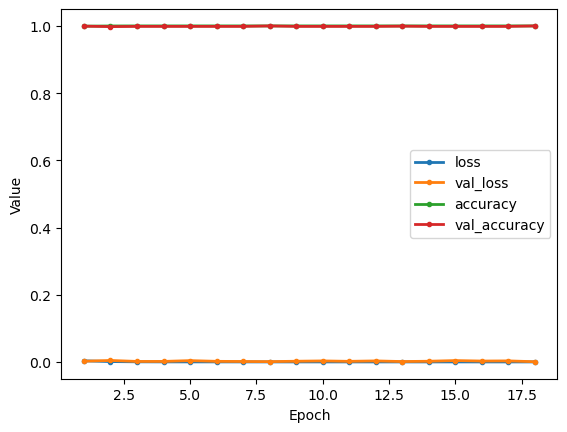

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/58 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

56/58 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 1/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
975,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4469,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5941,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1354,0.000919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5644,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      39,033,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,074,305 (149.06 MB)

 Trainable params: 39,074,305 (149.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1:02 685ms/step - accuracy: 0.5469 - loss: 0.6931

 2/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 0.5469 - loss: 0.6931 

 3/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - accuracy: 0.5434 - loss: 0.6930

 4/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - accuracy: 0.5443 - loss: 0.6929

 5/92 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - accuracy: 0.5398 - loss: 0.6929

 6/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.5371 - loss: 0.6928

 7/92 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.5340 - loss: 0.6928 

 8/92 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.5310 - loss: 0.6927

 9/92 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.5275 - loss: 0.6926

10/92 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.5254 - loss: 0.6926

11/92 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.5265 - loss: 0.6925

12/92 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.5293 - loss: 0.6923

13/92 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.5332 - loss: 0.6922

14/92 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.5366 - loss: 0.6920

15/92 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.5391 - loss: 0.6918

16/92 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 0.5412 - loss: 0.6916

17/92 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.5430 - loss: 0.6914

18/92 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.5446 - loss: 0.6911

19/92 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 0.5467 - loss: 0.6908

20/92 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.5493 - loss: 0.6905

21/92 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.5521 - loss: 0.6902

22/92 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.5552 - loss: 0.6898

23/92 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 0.5587 - loss: 0.6895

24/92 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 0.5625 - loss: 0.6890

25/92 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.5664 - loss: 0.6886

26/92 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.5703 - loss: 0.6881

27/92 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.5744 - loss: 0.6876

28/92 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.5784 - loss: 0.6871

29/92 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.5824 - loss: 0.6865

30/92 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.5865 - loss: 0.6859

31/92 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.5905 - loss: 0.6852

32/92 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.5946 - loss: 0.6845

33/92 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.5986 - loss: 0.6837

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.6026 - loss: 0.6828

35/92 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.6065 - loss: 0.6819

36/92 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.6104 - loss: 0.6809

37/92 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.6142 - loss: 0.6799

38/92 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.6180 - loss: 0.6789

39/92 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.6217 - loss: 0.6777

40/92 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.6253 - loss: 0.6765

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.6289 - loss: 0.6752

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.6325 - loss: 0.6738

43/92 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.6359 - loss: 0.6724

44/92 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.6394 - loss: 0.6709

45/92 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.6428 - loss: 0.6693

46/92 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.6461 - loss: 0.6676

47/92 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.6494 - loss: 0.6658

48/92 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.6526 - loss: 0.6640

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.6558 - loss: 0.6622

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.6589 - loss: 0.6602

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.6619 - loss: 0.6583

52/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.6649 - loss: 0.6562

53/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.6679 - loss: 0.6541

54/92 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.6708 - loss: 0.6520

55/92 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.6736 - loss: 0.6497

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.6764 - loss: 0.6475

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.6791 - loss: 0.6452

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.6818 - loss: 0.6429

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.6845 - loss: 0.6405

60/92 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.6871 - loss: 0.6381

61/92 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.6896 - loss: 0.6356

62/92 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.6921 - loss: 0.6331

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.6946 - loss: 0.6306

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.6970 - loss: 0.6281

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.6994 - loss: 0.6256

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.7018 - loss: 0.6230

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.7041 - loss: 0.6204

68/92 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.7064 - loss: 0.6178

69/92 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.7086 - loss: 0.6152

70/92 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.7108 - loss: 0.6126

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.7130 - loss: 0.6100

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.7151 - loss: 0.6074

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.7172 - loss: 0.6047

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.7192 - loss: 0.6021

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.7213 - loss: 0.5995

76/92 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.7233 - loss: 0.5969

77/92 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.7252 - loss: 0.5943

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.7272 - loss: 0.5916

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.7291 - loss: 0.5890

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.7310 - loss: 0.5864

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.7328 - loss: 0.5838

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.7346 - loss: 0.5812

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.7364 - loss: 0.5787

84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7382 - loss: 0.5761

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.7399 - loss: 0.5735

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.7417 - loss: 0.5710

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7434 - loss: 0.5685

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7450 - loss: 0.5660

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7467 - loss: 0.5635

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7483 - loss: 0.5610

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7499 - loss: 0.5585

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.7514 - loss: 0.5561

92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 155ms/step - accuracy: 0.7530 - loss: 0.5537 - val_accuracy: 0.9986 - val_loss: 0.0094


Epoch 2/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 26s 290ms/step - accuracy: 0.9844 - loss: 0.0305

 2/92 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.9883 - loss: 0.0242

 3/92 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.9905 - loss: 0.0211

 4/92 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9919 - loss: 0.0195

 5/92 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9929 - loss: 0.0184

 6/92 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.9936 - loss: 0.0174

 7/92 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9942 - loss: 0.0167

 8/92 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9947 - loss: 0.0160

 9/92 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9951 - loss: 0.0154

10/92 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9954 - loss: 0.0149

11/92 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9957 - loss: 0.0144

12/92 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9960 - loss: 0.0139

13/92 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9962 - loss: 0.0135

14/92 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.9964 - loss: 0.0131

15/92 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.9965 - loss: 0.0127

16/92 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9966 - loss: 0.0125 

17/92 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9966 - loss: 0.0123

18/92 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9967 - loss: 0.0121

19/92 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9967 - loss: 0.0119

20/92 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9968 - loss: 0.0116

21/92 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.9968 - loss: 0.0114

22/92 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9968 - loss: 0.0112

23/92 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.9969 - loss: 0.0111

24/92 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9969 - loss: 0.0109

25/92 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9970 - loss: 0.0107

26/92 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9970 - loss: 0.0106

27/92 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9971 - loss: 0.0104

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9971 - loss: 0.0103

29/92 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9972 - loss: 0.0101

30/92 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.9972 - loss: 0.0100

31/92 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9973 - loss: 0.0098

32/92 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9973 - loss: 0.0097

33/92 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9973 - loss: 0.0096

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9973 - loss: 0.0095

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9974 - loss: 0.0094

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9974 - loss: 0.0093

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9974 - loss: 0.0092

38/92 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.9974 - loss: 0.0091

39/92 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.9975 - loss: 0.0091

40/92 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.9975 - loss: 0.0090

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.9975 - loss: 0.0089

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.9975 - loss: 0.0088

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.9975 - loss: 0.0088

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.9975 - loss: 0.0087

45/92 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.9976 - loss: 0.0086

46/92 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9976 - loss: 0.0085

47/92 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9976 - loss: 0.0085

48/92 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9976 - loss: 0.0084

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9976 - loss: 0.0083

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9976 - loss: 0.0083

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9976 - loss: 0.0082

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9977 - loss: 0.0081

53/92 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9977 - loss: 0.0081

54/92 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9977 - loss: 0.0080

55/92 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9977 - loss: 0.0080

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9977 - loss: 0.0079

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9977 - loss: 0.0079

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9977 - loss: 0.0078

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9977 - loss: 0.0077

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9977 - loss: 0.0077

61/92 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9978 - loss: 0.0076

62/92 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9978 - loss: 0.0076

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9978 - loss: 0.0075

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9978 - loss: 0.0075

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9978 - loss: 0.0075

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9978 - loss: 0.0074

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9978 - loss: 0.0074

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9978 - loss: 0.0073

69/92 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9979 - loss: 0.0073

70/92 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9979 - loss: 0.0072

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9979 - loss: 0.0072

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9979 - loss: 0.0072

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9979 - loss: 0.0071

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9979 - loss: 0.0071

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9979 - loss: 0.0071

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9979 - loss: 0.0070

77/92 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9979 - loss: 0.0070

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9979 - loss: 0.0070

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9979 - loss: 0.0070

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9980 - loss: 0.0069

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9980 - loss: 0.0069

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9980 - loss: 0.0069

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9980 - loss: 0.0068

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9980 - loss: 0.0068

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9980 - loss: 0.0068

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9980 - loss: 0.0068

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9980 - loss: 0.0067

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9980 - loss: 0.0067

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9980 - loss: 0.0067

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9980 - loss: 0.0067

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9980 - loss: 0.0066

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9981 - loss: 0.0066

92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 0.9981 - loss: 0.0066 - val_accuracy: 0.9986 - val_loss: 0.0041


Epoch 3/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 16s 186ms/step - accuracy: 1.0000 - loss: 0.0011

 2/92 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 9.0598e-04

 3/92 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 8.2891e-04

 4/92 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 1.0000 - loss: 7.7299e-04

 5/92 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 7.4503e-04

 6/92 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 7.4181e-04

 7/92 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 7.4899e-04

 8/92 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 7.5027e-04

 9/92 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 7.5070e-04

10/92 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 7.4727e-04

11/92 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 7.4312e-04

12/92 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 7.7404e-04

13/92 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 1.0000 - loss: 8.0128e-04

14/92 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 8.2188e-04

15/92 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - accuracy: 1.0000 - loss: 8.4528e-04

16/92 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - accuracy: 1.0000 - loss: 8.6350e-04

17/92 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - accuracy: 1.0000 - loss: 8.7732e-04

18/92 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 1.0000 - loss: 8.8742e-04

19/92 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 1.0000 - loss: 8.9506e-04

20/92 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 1.0000 - loss: 9.0102e-04

21/92 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 1.0000 - loss: 9.0528e-04

22/92 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 1.0000 - loss: 9.0796e-04

23/92 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 1.0000 - loss: 9.1060e-04

24/92 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 1.0000 - loss: 9.1212e-04

25/92 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 1.0000 - loss: 9.1305e-04

26/92 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 9.1381e-04 

27/92 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 9.1463e-04

28/92 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 9.1555e-04

29/92 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 9.1590e-04

30/92 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 9.1575e-04

31/92 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 9.1517e-04

32/92 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 9.1432e-04

33/92 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 9.1344e-04

34/92 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 9.1209e-04

35/92 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 9.1065e-04

36/92 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 9.1105e-04

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 9.1125e-04

38/92 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 9.1104e-04

39/92 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 9.1054e-04

40/92 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 9.1190e-04

41/92 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 9.1284e-04

42/92 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 1.0000 - loss: 9.1344e-04

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 1.0000 - loss: 9.1401e-04

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 1.0000 - loss: 9.1423e-04

45/92 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 9.1430e-04

46/92 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 9.1419e-04

47/92 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 9.1428e-04

48/92 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 9.1423e-04

49/92 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 9.1398e-04

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 9.1370e-04

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 9.1328e-04

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 9.1270e-04

53/92 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 9.1206e-04

54/92 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 9.1134e-04

55/92 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 9.1049e-04

56/92 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 9.0955e-04

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 9.0851e-04

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 9.0736e-04

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 9.0610e-04

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 9.0473e-04

61/92 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 9.0326e-04

62/92 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 9.0172e-04

63/92 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 9.0013e-04

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 8.9858e-04

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 8.9695e-04

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 8.9536e-04

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 8.9368e-04

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 8.9200e-04

69/92 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 8.9029e-04

70/92 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 8.8851e-04

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 8.8673e-04

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 8.8500e-04

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 8.8323e-04

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 8.8139e-04

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 8.7952e-04

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 8.7769e-04

77/92 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 8.7582e-04

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 8.7394e-04

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 8.7205e-04

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 8.7012e-04

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 8.6817e-04

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 8.6622e-04

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 8.6427e-04

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 8.6231e-04

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 8.6032e-04

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 8.5832e-04

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 8.5632e-04

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 8.5432e-04

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 8.5230e-04

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 8.5027e-04

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 8.4824e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 8.4627e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 1.0000 - loss: 8.4435e-04 - val_accuracy: 0.9993 - val_loss: 0.0035


Epoch 4/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 37s 412ms/step - accuracy: 1.0000 - loss: 1.8767e-04

 2/92 ━━━━━━━━━━━━━━━━━━━━ 15s 174ms/step - accuracy: 1.0000 - loss: 2.0982e-04

 3/92 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 1.0000 - loss: 2.0588e-04

 4/92 ━━━━━━━━━━━━━━━━━━━━ 13s 151ms/step - accuracy: 1.0000 - loss: 1.9852e-04

 5/92 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 1.9251e-04

 6/92 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 1.9457e-04

 7/92 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 1.9525e-04

 8/92 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 1.9531e-04

 9/92 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 1.0000 - loss: 1.9504e-04

10/92 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 1.0000 - loss: 1.9651e-04

11/92 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 1.0000 - loss: 1.9784e-04

12/92 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 1.0000 - loss: 2.0403e-04

13/92 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 1.0000 - loss: 2.0875e-04

14/92 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 2.1327e-04

15/92 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 2.1683e-04

16/92 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 2.1986e-04

17/92 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 2.2229e-04

18/92 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 1.0000 - loss: 2.2415e-04

19/92 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 2.2577e-04 

20/92 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 2.2689e-04

21/92 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 2.2776e-04

22/92 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 2.2819e-04

23/92 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 2.2855e-04

24/92 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 2.2874e-04

25/92 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 2.2881e-04

26/92 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 2.2879e-04

27/92 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 1.0000 - loss: 2.2870e-04

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 1.0000 - loss: 2.2850e-04

29/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 2.2821e-04

30/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 2.2791e-04

31/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 2.2750e-04

32/92 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 1.0000 - loss: 2.2704e-04

33/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 2.2658e-04

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 2.2607e-04

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 2.2565e-04

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 2.2520e-04

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 1.0000 - loss: 2.2472e-04

38/92 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 1.0000 - loss: 2.2426e-04

39/92 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 2.2399e-04

40/92 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 2.2378e-04

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 2.2353e-04

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 2.2325e-04

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 2.2295e-04

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 2.2300e-04

45/92 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 2.2298e-04

46/92 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 2.2292e-04

47/92 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 2.2282e-04

48/92 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 2.2267e-04

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 2.2252e-04

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 2.2241e-04

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 2.2226e-04

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 2.2208e-04

53/92 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 2.2186e-04

54/92 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 2.2161e-04

55/92 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 2.2139e-04

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 2.2116e-04

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 2.2091e-04

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 2.2065e-04

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 2.2037e-04

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 2.2012e-04

61/92 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 2.1986e-04

62/92 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 2.1961e-04

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 2.1935e-04

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 2.1916e-04

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 2.1896e-04

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 2.1875e-04

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 2.1852e-04

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.1829e-04

69/92 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.1805e-04

70/92 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 2.1781e-04

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 2.1756e-04

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 2.1729e-04

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 2.1700e-04

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 2.1670e-04

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 2.1640e-04

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 2.1612e-04

77/92 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 2.1584e-04

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 2.1555e-04

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 2.1527e-04

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 2.1499e-04

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 2.1470e-04

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 2.1441e-04

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 2.1412e-04

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 2.1382e-04

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.1352e-04

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.1321e-04

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.1290e-04

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.1259e-04

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.1227e-04

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 2.1198e-04

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.1168e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 2.1138e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 1.0000 - loss: 2.1109e-04 - val_accuracy: 0.9993 - val_loss: 0.0036


Epoch 5/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 24s 273ms/step - accuracy: 1.0000 - loss: 1.1530e-04

 2/92 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 1.2287e-04

 3/92 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 1.0000 - loss: 1.1750e-04

 4/92 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 1.0000 - loss: 1.1224e-04

 5/92 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 1.0000 - loss: 1.1013e-04

 6/92 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 1.0000 - loss: 1.3326e-04

 7/92 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 1.0000 - loss: 1.4629e-04

 8/92 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 1.0000 - loss: 1.5323e-04

 9/92 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 1.0000 - loss: 1.5746e-04

10/92 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 1.5985e-04

11/92 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 1.6190e-04

12/92 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 1.0000 - loss: 1.6304e-04

13/92 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 1.0000 - loss: 1.6362e-04

14/92 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 1.6377e-04

15/92 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 1.6345e-04

16/92 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 1.6300e-04 

17/92 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 1.6252e-04

18/92 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 1.6237e-04

19/92 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 1.6208e-04

20/92 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 1.6202e-04

21/92 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 1.6173e-04

22/92 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 1.6132e-04

23/92 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 1.6087e-04

24/92 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 1.6037e-04

25/92 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 1.5976e-04

26/92 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 1.5913e-04

27/92 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 1.5850e-04

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 1.5780e-04

29/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 1.5712e-04

30/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 1.5643e-04

31/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 1.0000 - loss: 1.5572e-04

32/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 1.5509e-04

33/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 1.5516e-04

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 1.5524e-04

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 1.0000 - loss: 1.5531e-04

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 1.0000 - loss: 1.5529e-04

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 1.0000 - loss: 1.5525e-04

38/92 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 1.0000 - loss: 1.5518e-04

39/92 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 1.5510e-04

40/92 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 1.5499e-04

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 1.5487e-04

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 1.5474e-04

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 1.5464e-04

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 1.5449e-04

45/92 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 1.5433e-04

46/92 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 1.5413e-04

47/92 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 1.5391e-04

48/92 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.5367e-04

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.5341e-04

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.5313e-04

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.5284e-04

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.5256e-04

53/92 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.5227e-04

54/92 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.5198e-04

55/92 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.5167e-04

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.5137e-04

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.5106e-04

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.5078e-04

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.5049e-04

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.5020e-04

61/92 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.4991e-04

62/92 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.4961e-04

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.4930e-04

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.4900e-04

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.4870e-04

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.4840e-04

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.4811e-04

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.4781e-04

69/92 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.4751e-04

70/92 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.4723e-04

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.4694e-04

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.4670e-04

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.4645e-04

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.4620e-04

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.4594e-04

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 1.4568e-04

77/92 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.4543e-04

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.4518e-04

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.4494e-04

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.4471e-04

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.4447e-04

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.4424e-04

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.4400e-04

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 1.4375e-04

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 1.4351e-04

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 1.4326e-04

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 1.4302e-04

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 1.4277e-04

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 1.4253e-04

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 1.4228e-04

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 1.4202e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 1.4178e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 1.0000 - loss: 1.4154e-04 - val_accuracy: 0.9993 - val_loss: 0.0036


Epoch 6/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 35s 386ms/step - accuracy: 1.0000 - loss: 5.4063e-05

 2/92 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 7.0025e-05

 3/92 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 6.9381e-05

 4/92 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 1.0000 - loss: 6.6478e-05

 5/92 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 1.0000 - loss: 7.2747e-05

 6/92 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 1.0000 - loss: 7.6838e-05

 7/92 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 7.9160e-05

 8/92 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 8.0350e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 8.0998e-05

10/92 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 8.1462e-05

11/92 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 8.1685e-05

12/92 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 8.1913e-05

13/92 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 8.1754e-05

14/92 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 8.1377e-05 

15/92 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 8.0926e-05

16/92 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 8.0487e-05

17/92 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 8.0077e-05

18/92 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 7.9588e-05

19/92 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 7.9183e-05

20/92 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 7.8862e-05

21/92 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 7.8710e-05

22/92 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 7.8524e-05

23/92 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 7.8300e-05

24/92 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 7.8127e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 7.7962e-05

26/92 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 7.7821e-05

27/92 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 7.7653e-05

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 7.7503e-05

29/92 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 7.7377e-05

30/92 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 7.7214e-05

31/92 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 7.7024e-05

32/92 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 7.6885e-05

33/92 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 7.6735e-05

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 7.6580e-05

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 7.6423e-05

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 7.6280e-05

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 7.6142e-05

38/92 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 7.5986e-05

39/92 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 7.6590e-05

40/92 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 7.7125e-05

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 7.7597e-05

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 7.8019e-05

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 7.8442e-05

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 7.8822e-05

45/92 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 7.9164e-05

46/92 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 7.9456e-05

47/92 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 7.9715e-05

48/92 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 7.9961e-05

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 8.0201e-05

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 8.0407e-05

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 8.0603e-05

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 8.0783e-05

53/92 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 8.0951e-05

54/92 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 8.1103e-05

55/92 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 8.1271e-05

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 8.1422e-05

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 8.1553e-05

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 8.1669e-05

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 8.1785e-05

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 8.1885e-05

61/92 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 8.1974e-05

62/92 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 8.2048e-05

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 8.2107e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 8.2159e-05

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 8.2202e-05

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 8.2241e-05

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 8.2264e-05

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 8.2281e-05

69/92 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 8.2296e-05

70/92 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 8.2303e-05

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 8.2306e-05

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 8.2301e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 8.2286e-05

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 8.2268e-05

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 8.2243e-05

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 8.2208e-05

77/92 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 8.2177e-05

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 8.2143e-05

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 8.2104e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 8.2060e-05

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 8.2026e-05

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 8.1988e-05

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 8.1950e-05

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 8.1909e-05

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 8.1868e-05

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 8.1823e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 8.1774e-05

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 8.1751e-05

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 8.1745e-05

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 8.1735e-05

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 8.1726e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 8.1718e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 1.0000 - loss: 8.1709e-05 - val_accuracy: 0.9993 - val_loss: 0.0030


Epoch 7/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 18s 207ms/step - accuracy: 1.0000 - loss: 5.2523e-05

 2/92 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 1.0000 - loss: 8.4936e-05

 3/92 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 9.3636e-05

 4/92 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 1.0000 - loss: 9.3174e-05

 5/92 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 1.0000 - loss: 9.1707e-05

 6/92 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 1.0000 - loss: 8.9211e-05

 7/92 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 1.0000 - loss: 8.7714e-05

 8/92 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 1.0000 - loss: 8.6200e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 1.0000 - loss: 8.4468e-05

10/92 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 1.0000 - loss: 8.2864e-05

11/92 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 8.1470e-05

12/92 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 8.0062e-05

13/92 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 7.8781e-05

14/92 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 1.0000 - loss: 7.7755e-05

15/92 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 7.6665e-05

16/92 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 1.0000 - loss: 7.5688e-05

17/92 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 1.0000 - loss: 7.4823e-05

18/92 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 7.4075e-05 

19/92 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 7.3436e-05

20/92 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 1.0000 - loss: 7.2848e-05

21/92 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 1.0000 - loss: 7.2464e-05

22/92 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 1.0000 - loss: 7.2102e-05

23/92 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 1.0000 - loss: 7.1707e-05

24/92 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 1.0000 - loss: 7.1296e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 1.0000 - loss: 7.0944e-05

26/92 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 7.0651e-05

27/92 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 7.0341e-05

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 7.0301e-05

29/92 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 7.0211e-05

30/92 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 7.0093e-05

31/92 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 6.9941e-05

32/92 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 6.9842e-05

33/92 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 6.9731e-05

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 6.9634e-05

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 6.9525e-05

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 6.9402e-05

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 6.9297e-05

38/92 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 6.9194e-05

39/92 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 6.9074e-05

40/92 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 6.8948e-05

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 6.8829e-05

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 6.8740e-05

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 6.8639e-05

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 6.8553e-05

45/92 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.8459e-05

46/92 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.8368e-05

47/92 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.8276e-05

48/92 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.8178e-05

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.8069e-05

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.7954e-05

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.7850e-05

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.7734e-05

53/92 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.7644e-05

54/92 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.7551e-05

55/92 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.7448e-05

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.7339e-05

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.7224e-05

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.7105e-05

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.6981e-05

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.6849e-05

61/92 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 6.6711e-05

62/92 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 6.6570e-05

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 6.6435e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 6.6297e-05

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 6.6155e-05

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 6.6015e-05

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 6.5873e-05

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 6.5731e-05

69/92 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 6.5588e-05

70/92 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 6.5444e-05

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 6.5300e-05

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 6.5152e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 6.5009e-05

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 6.4868e-05

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 6.4727e-05

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 6.4588e-05

77/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 6.4446e-05

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 6.4313e-05

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 6.4180e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 6.4053e-05

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 6.3926e-05

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 6.3800e-05

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 6.3694e-05

84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 6.3585e-05

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 6.3477e-05

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 6.3368e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 6.3256e-05

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 6.3141e-05

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 6.3025e-05

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.2908e-05

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.2791e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.2676e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 1.0000 - loss: 6.2565e-05 - val_accuracy: 0.9993 - val_loss: 0.0035


Epoch 8/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 20s 221ms/step - accuracy: 1.0000 - loss: 2.7625e-05

 2/92 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 1.0000 - loss: 2.6687e-05 

 3/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 1.0000 - loss: 2.7350e-05

 4/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - accuracy: 1.0000 - loss: 2.7591e-05

 5/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 1.0000 - loss: 2.8708e-05

 6/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 1.0000 - loss: 3.1396e-05

 7/92 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 1.0000 - loss: 3.3716e-05

 8/92 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 3.5023e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 3.5796e-05

10/92 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 3.6413e-05

11/92 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 3.6751e-05

12/92 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 3.6914e-05 

13/92 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 3.6958e-05

14/92 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 3.6896e-05

15/92 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 3.6848e-05

16/92 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 3.6791e-05

17/92 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 3.6794e-05

18/92 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 3.7068e-05

19/92 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 3.7293e-05

20/92 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 3.7668e-05

21/92 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 3.8001e-05

22/92 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 3.8265e-05

23/92 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 3.8506e-05

24/92 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 3.8689e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 3.9094e-05

26/92 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 3.9500e-05

27/92 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 3.9835e-05

28/92 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 4.0141e-05

29/92 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 4.0390e-05

30/92 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 4.0631e-05

31/92 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 4.0847e-05

32/92 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 4.1045e-05

33/92 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 4.1222e-05

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 4.1364e-05

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 4.1478e-05

36/92 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 4.1567e-05

37/92 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 4.1642e-05

38/92 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 4.1701e-05

39/92 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 4.1748e-05

40/92 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 4.1785e-05

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 4.2214e-05

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 4.2617e-05

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 4.2984e-05

44/92 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 4.3326e-05

45/92 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 4.3634e-05

46/92 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 4.3924e-05

47/92 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 4.4186e-05

48/92 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 4.4420e-05

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 4.4637e-05

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 4.4853e-05

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 4.5057e-05

52/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 4.5245e-05

53/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 4.5414e-05

54/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 4.5576e-05

55/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 4.5735e-05

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 4.5882e-05

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 4.6028e-05

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 4.6161e-05

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 4.6280e-05

60/92 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 4.6392e-05

61/92 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 4.6498e-05

62/92 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 4.6593e-05

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 4.6682e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 4.6766e-05

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 4.6839e-05

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 4.6902e-05

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 4.6960e-05

68/92 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 4.7010e-05

69/92 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 4.7053e-05

70/92 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 4.7086e-05

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 4.7111e-05

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 4.7131e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 4.7145e-05

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 4.7155e-05

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 4.7160e-05

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 4.7160e-05

77/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.7156e-05

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.7147e-05

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 4.7140e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 4.7128e-05

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.7118e-05

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 4.7104e-05

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 4.7086e-05

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 4.7067e-05

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 4.7046e-05

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 4.7020e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 4.6993e-05

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 4.6966e-05

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 4.6938e-05

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 4.6908e-05

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 4.6877e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.6847e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 1.0000 - loss: 4.6818e-05 - val_accuracy: 0.9993 - val_loss: 0.0033


Epoch 9/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 47s 526ms/step - accuracy: 1.0000 - loss: 1.8512e-05

 2/92 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.7199e-05

 3/92 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 1.0000 - loss: 1.7681e-05

 4/92 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 1.0000 - loss: 1.7534e-05

 5/92 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 1.0000 - loss: 1.7793e-05

 6/92 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 1.7927e-05

 7/92 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 1.0000 - loss: 1.8143e-05

 8/92 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 1.8239e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.8358e-05

10/92 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 1.8444e-05

11/92 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 1.9297e-05

12/92 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 2.0123e-05

13/92 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 2.0711e-05

14/92 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 2.1662e-05

15/92 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 2.3098e-05 

16/92 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 2.4265e-05

17/92 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 2.5215e-05

18/92 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 2.6010e-05

19/92 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 1.0000 - loss: 2.6674e-05

20/92 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 2.7278e-05

21/92 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 2.7796e-05

22/92 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.8225e-05

23/92 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.8567e-05

24/92 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.8854e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.9108e-05

26/92 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.9311e-05

27/92 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 2.9476e-05

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 2.9655e-05

29/92 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.9831e-05

30/92 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.9991e-05

31/92 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 3.0123e-05

32/92 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 3.0263e-05

33/92 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 3.0378e-05

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 3.0475e-05

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 3.0905e-05

36/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 3.1284e-05

37/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 3.1619e-05

38/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 3.1918e-05

39/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 3.2186e-05

40/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 3.2423e-05

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 3.2642e-05

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 3.2843e-05

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 3.3037e-05

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 3.3211e-05

45/92 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 3.3378e-05

46/92 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 3.3529e-05

47/92 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 3.3689e-05

48/92 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 3.3857e-05

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 3.4007e-05

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 3.4143e-05

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 3.4271e-05

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 3.4396e-05

53/92 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.4510e-05

54/92 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.4615e-05

55/92 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 3.4712e-05

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.4801e-05

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.4892e-05

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.4975e-05

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.5049e-05

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.5112e-05

61/92 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.5173e-05

62/92 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.5231e-05

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.5301e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.5364e-05

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.5418e-05

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.5467e-05

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 3.5511e-05

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 3.5558e-05

69/92 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 3.5599e-05

70/92 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 3.5637e-05

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 3.5668e-05

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 3.5694e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 3.5732e-05

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 3.5814e-05

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 3.5901e-05

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 3.5982e-05

77/92 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.6057e-05

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.6139e-05

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.6215e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 3.6285e-05

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.6350e-05

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.6411e-05

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.6469e-05

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.6525e-05

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.6577e-05

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.6626e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.6671e-05

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.6712e-05

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.6751e-05

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.6787e-05

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.6820e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.6852e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 1.0000 - loss: 3.6883e-05 - val_accuracy: 0.9993 - val_loss: 0.0030


Epoch 10/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 21s 239ms/step - accuracy: 1.0000 - loss: 3.4559e-05

 2/92 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 1.0000 - loss: 3.0346e-05

 3/92 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 1.0000 - loss: 2.7491e-05

 4/92 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 2.5871e-05

 5/92 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 2.4951e-05

 6/92 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 2.4086e-05

 7/92 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 2.3704e-05

 8/92 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 2.3326e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 2.3007e-05

10/92 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 2.2844e-05

11/92 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 2.2639e-05

12/92 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 2.2673e-05

13/92 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.2640e-05 

14/92 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.2657e-05

15/92 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.2684e-05

16/92 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.2692e-05

17/92 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 2.2748e-05

18/92 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 2.2773e-05

19/92 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 2.2811e-05

20/92 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 2.2852e-05

21/92 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 2.2872e-05

22/92 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 2.2893e-05

23/92 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 2.2906e-05

24/92 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 2.2899e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 2.2890e-05

26/92 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 2.2892e-05

27/92 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 2.2914e-05

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 2.2948e-05

29/92 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.2967e-05

30/92 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.3020e-05

31/92 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.3062e-05

32/92 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.3097e-05

33/92 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.3167e-05

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.3228e-05

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.3280e-05

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 2.3334e-05

37/92 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 2.3386e-05

38/92 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 2.3452e-05

39/92 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 2.3505e-05

40/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.3557e-05

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 2.3607e-05

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.3660e-05

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.3707e-05

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.3746e-05

45/92 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.3781e-05

46/92 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.3813e-05

47/92 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.3836e-05

48/92 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 2.3855e-05

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 2.3872e-05

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 2.3882e-05

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 2.3888e-05

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 2.3895e-05

53/92 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.3898e-05

54/92 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 2.3894e-05

55/92 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 2.3891e-05

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 2.3885e-05

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 2.3877e-05

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 2.3867e-05

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 2.3854e-05

60/92 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 2.3842e-05

61/92 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 2.3831e-05

62/92 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 2.3818e-05

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 2.3805e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 2.3794e-05

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 2.3786e-05

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 2.3777e-05

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 2.3767e-05

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 2.3759e-05

69/92 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 2.3750e-05

70/92 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.3744e-05

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 2.3740e-05

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.3738e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.3734e-05

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 2.3729e-05

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 2.3722e-05

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.3712e-05

77/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 2.3705e-05

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 2.3697e-05

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 2.3689e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 2.3680e-05

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 2.3691e-05

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 2.3700e-05

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 2.3708e-05

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 2.3714e-05

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.3718e-05

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.3721e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.3722e-05

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.3724e-05

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.3723e-05

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 2.3733e-05

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.3782e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 2.3829e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 1.0000 - loss: 2.3874e-05 - val_accuracy: 0.9993 - val_loss: 0.0033


Epoch 11/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 26s 294ms/step - accuracy: 1.0000 - loss: 7.9901e-06

 2/92 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 1.2195e-05

 3/92 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 1.0000 - loss: 1.4287e-05

 4/92 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 1.4803e-05

 5/92 ━━━━━━━━━━━━━━━━━━━━ 14s 165ms/step - accuracy: 1.0000 - loss: 1.4804e-05

 6/92 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - accuracy: 1.0000 - loss: 1.4709e-05

 7/92 ━━━━━━━━━━━━━━━━━━━━ 13s 155ms/step - accuracy: 1.0000 - loss: 1.4773e-05

 8/92 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - accuracy: 1.0000 - loss: 1.4693e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 1.0000 - loss: 1.4563e-05

10/92 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 1.4519e-05

11/92 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 1.4499e-05

12/92 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 1.4653e-05

13/92 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 1.4768e-05

14/92 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 1.4836e-05

15/92 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.4863e-05

16/92 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 1.4979e-05

17/92 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 1.0000 - loss: 1.5083e-05

18/92 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 1.0000 - loss: 1.5174e-05

19/92 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 1.5227e-05

20/92 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 1.5342e-05 

21/92 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 1.5428e-05

22/92 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 1.5514e-05

23/92 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 1.5599e-05

24/92 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 1.5697e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 1.5776e-05

26/92 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 1.5843e-05

27/92 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 1.0000 - loss: 1.5933e-05

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 1.0000 - loss: 1.6007e-05

29/92 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 1.0000 - loss: 1.6075e-05

30/92 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 1.0000 - loss: 1.6144e-05

31/92 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 1.0000 - loss: 1.6240e-05

32/92 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 1.0000 - loss: 1.6323e-05

33/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 1.6402e-05

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 1.6475e-05

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 1.6537e-05

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 1.6591e-05

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 1.6657e-05

38/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 1.6786e-05

39/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 1.6911e-05

40/92 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 1.7030e-05

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 1.7135e-05

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 1.7230e-05

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 1.7316e-05

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 1.7392e-05

45/92 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 1.7466e-05

46/92 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 1.7543e-05

47/92 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 1.7637e-05

48/92 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 1.7725e-05

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 1.7812e-05

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 1.7889e-05

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 1.7959e-05

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.8044e-05

53/92 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.8122e-05

54/92 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.8195e-05

55/92 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.8261e-05

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.8323e-05

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.8379e-05

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.8429e-05

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.8479e-05

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.8526e-05

61/92 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.8574e-05

62/92 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 1.8617e-05

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 1.8658e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 1.8699e-05

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 1.8739e-05

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 1.8777e-05

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 1.8811e-05

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.8841e-05

69/92 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 1.8871e-05

70/92 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 1.8900e-05

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 1.8926e-05

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 1.8949e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 1.8976e-05

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 1.9000e-05

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 1.9022e-05

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 1.9044e-05

77/92 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.9068e-05

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.9093e-05

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.9120e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.9156e-05

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.9194e-05

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.9231e-05

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.9268e-05

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.9305e-05

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.9338e-05

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.9371e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.9402e-05

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.9431e-05

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.9462e-05

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.9491e-05

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.9524e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 1.9557e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 1.0000 - loss: 1.9588e-05 - val_accuracy: 0.9993 - val_loss: 0.0035


Epoch 12/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 21s 233ms/step - accuracy: 1.0000 - loss: 9.2869e-06

 2/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 1.0000 - loss: 8.9850e-06

 3/92 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 1.2458e-05

 4/92 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 1.0000 - loss: 1.3601e-05

 5/92 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 1.3788e-05

 6/92 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 1.3948e-05

 7/92 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 1.4362e-05

 8/92 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 1.4527e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 1.4550e-05

10/92 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 1.4602e-05

11/92 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 1.4593e-05

12/92 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 1.4982e-05

13/92 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.5351e-05

14/92 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 1.9805e-05 

15/92 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 2.3424e-05

16/92 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.6366e-05

17/92 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 3.1016e-05

18/92 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 3.4849e-05

19/92 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 3.8034e-05

20/92 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 4.0706e-05

21/92 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 4.2959e-05

22/92 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 4.4844e-05

23/92 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 4.6416e-05

24/92 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 4.7728e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 4.8929e-05

26/92 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 4.9942e-05

27/92 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 5.0787e-05

28/92 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 5.1538e-05

29/92 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 5.2166e-05

30/92 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 5.2690e-05

31/92 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 5.3129e-05

32/92 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 5.3483e-05

33/92 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 5.3768e-05

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 5.3999e-05

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 5.4317e-05

36/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 5.4575e-05

37/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 5.4778e-05

38/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 5.4938e-05

39/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 5.5054e-05

40/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 5.5136e-05

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 5.5195e-05

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 5.5225e-05

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 5.5233e-05

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 5.5221e-05

45/92 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 5.5187e-05

46/92 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 5.5133e-05

47/92 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 5.5063e-05

48/92 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 5.4980e-05

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 5.4883e-05

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 5.4775e-05

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 5.4655e-05

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 5.4552e-05

53/92 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 5.4472e-05

54/92 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 5.4380e-05

55/92 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 5.4287e-05

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 5.4186e-05

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 5.4076e-05

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 5.3960e-05

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 5.3837e-05

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 5.3711e-05

61/92 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 5.3585e-05

62/92 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 5.3458e-05

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 5.3341e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 5.3220e-05

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 5.3094e-05

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 5.2964e-05

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 5.2831e-05

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 5.2694e-05

69/92 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 5.2554e-05

70/92 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 5.2411e-05

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 5.2268e-05

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 5.2122e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 5.1980e-05

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 5.1835e-05

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 5.1690e-05

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 5.1558e-05

77/92 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 5.1425e-05

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 5.1291e-05

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 5.1161e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 5.1029e-05

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 5.0898e-05

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 5.0766e-05

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 5.0634e-05

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 5.0503e-05

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 5.0371e-05

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 5.0238e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 5.0103e-05

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 4.9968e-05

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 4.9836e-05

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 4.9705e-05

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 4.9572e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 4.9444e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 1.0000 - loss: 4.9319e-05 - val_accuracy: 0.9993 - val_loss: 0.0033


Epoch 13/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 22s 244ms/step - accuracy: 1.0000 - loss: 1.0059e-05

 2/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 1.0000 - loss: 9.6034e-06

 3/92 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 1.1778e-05

 4/92 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 1.4614e-05

 5/92 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 1.5539e-05

 6/92 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 1.6016e-05

 7/92 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 1.0000 - loss: 1.6402e-05

 8/92 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 1.6657e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 1.7016e-05

10/92 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 1.7167e-05

11/92 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 1.7266e-05

12/92 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 1.0000 - loss: 1.7282e-05

13/92 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 1.7233e-05

14/92 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 1.0000 - loss: 1.7173e-05

15/92 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 1.7113e-05

16/92 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 1.7036e-05 

17/92 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 1.0000 - loss: 1.6937e-05

18/92 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 1.6831e-05

19/92 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 1.6763e-05

20/92 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 1.0000 - loss: 1.6786e-05

21/92 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 1.0000 - loss: 1.6795e-05

22/92 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 1.0000 - loss: 1.6786e-05

23/92 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 1.0000 - loss: 1.6765e-05

24/92 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 1.0000 - loss: 1.6738e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 1.0000 - loss: 1.6710e-05

26/92 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 1.0000 - loss: 1.6669e-05 

27/92 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 1.0000 - loss: 1.6622e-05

28/92 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 1.6573e-05

29/92 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 1.6515e-05

30/92 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 1.6453e-05

31/92 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 1.6388e-05

32/92 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 1.0000 - loss: 1.6328e-05

33/92 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 1.0000 - loss: 1.6263e-05

34/92 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 1.0000 - loss: 1.6193e-05

35/92 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 1.0000 - loss: 1.6129e-05

36/92 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 1.0000 - loss: 1.6076e-05

37/92 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 1.0000 - loss: 1.6023e-05

38/92 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 1.0000 - loss: 1.5973e-05

39/92 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - accuracy: 1.0000 - loss: 1.5928e-05

40/92 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - accuracy: 1.0000 - loss: 1.5880e-05

41/92 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 1.0000 - loss: 1.5831e-05

42/92 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 1.0000 - loss: 1.5779e-05

43/92 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 1.0000 - loss: 1.5726e-05

44/92 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 1.0000 - loss: 1.5673e-05

45/92 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 1.0000 - loss: 1.5619e-05

46/92 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 1.0000 - loss: 1.5565e-05

47/92 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 1.0000 - loss: 1.5510e-05

48/92 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 1.0000 - loss: 1.5455e-05

49/92 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 1.0000 - loss: 1.5399e-05

50/92 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 1.0000 - loss: 1.5348e-05

51/92 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 1.0000 - loss: 1.5296e-05

52/92 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 1.0000 - loss: 1.5243e-05

53/92 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 1.0000 - loss: 1.5192e-05

54/92 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 1.0000 - loss: 1.5206e-05

55/92 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 1.0000 - loss: 1.5217e-05

56/92 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 1.0000 - loss: 1.5226e-05

57/92 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 1.0000 - loss: 1.5232e-05

58/92 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 1.0000 - loss: 1.5247e-05

59/92 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 1.0000 - loss: 1.5267e-05

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 1.0000 - loss: 1.5286e-05

61/92 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 1.0000 - loss: 1.5301e-05

62/92 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 1.0000 - loss: 1.5313e-05

63/92 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 1.0000 - loss: 1.5323e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 1.0000 - loss: 1.5330e-05

65/92 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 1.0000 - loss: 1.5333e-05

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 1.0000 - loss: 1.5335e-05

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 1.0000 - loss: 1.5335e-05

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 1.0000 - loss: 1.5333e-05

69/92 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 1.0000 - loss: 1.5329e-05

70/92 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 1.0000 - loss: 1.5325e-05

71/92 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 1.0000 - loss: 1.5323e-05

72/92 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 1.0000 - loss: 1.5319e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 1.0000 - loss: 1.5314e-05

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 1.0000 - loss: 1.5307e-05

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 1.0000 - loss: 1.5300e-05

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 1.0000 - loss: 1.5291e-05

77/92 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 1.0000 - loss: 1.5283e-05

78/92 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 1.0000 - loss: 1.5274e-05

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 1.0000 - loss: 1.5265e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 1.0000 - loss: 1.5255e-05

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 1.0000 - loss: 1.5245e-05

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 1.0000 - loss: 1.5235e-05

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 1.5224e-05

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 1.5213e-05

85/92 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 1.5201e-05

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 1.5189e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 1.5176e-05

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 1.5165e-05

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 1.5153e-05

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 1.5140e-05

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 1.5128e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 1.5115e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 157ms/step - accuracy: 1.0000 - loss: 1.5102e-05 - val_accuracy: 0.9993 - val_loss: 0.0032



[Train Accuracy: 100.00% - Test Accuracy: 99.84%]


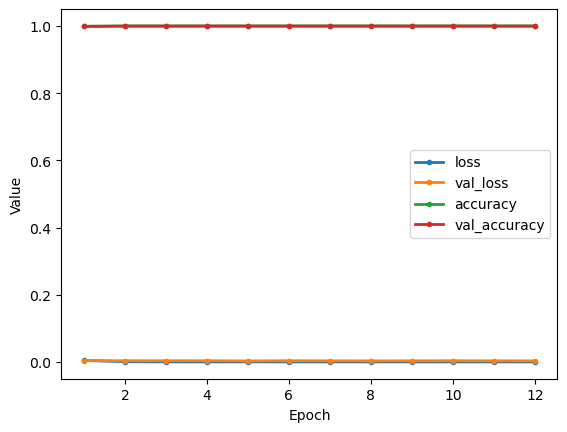

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/58 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step

 6/58 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 

11/58 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

16/58 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

21/58 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

26/58 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

31/58 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

36/58 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

42/58 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

47/58 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

52/58 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


 1/58 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step

 6/58 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 

11/58 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

16/58 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

21/58 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

26/58 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

31/58 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

36/58 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

42/58 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

48/58 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

54/58 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [25]:
report.save()

Report saved as Output/Reports/ARF/report_SR9QDKLP.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################